## Load dataset and libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#%cd /gdrive/My Drive/MachineLearningUSYD/Assignment2COMP4318/
#%cd /gdrive/My Drive/Assignment2COMP4318/

/gdrive/.shortcut-targets-by-id/1nf3_aum3xkoBPKcB_3Wt8f3ReYjjgq_O/Assignment2COMP4318


In [ ]:
DATA = "training.300000.processed.noemoticon.csv"

In [ ]:
#Load required libraries
import sys
import pandas as pd
import re
import keras
import nltk
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import tensorflow
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, GlobalMaxPool1D, Conv1D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
# Print Python version
print("Python version:", sys.version)

# Print library versions
print("pandas version:", pd.__version__)
print("nltk version:", nltk.__version__)
print("keras version:", keras.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("tensorflow version:", tensorflow.__version__)

Python version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
pandas version: 1.5.3
nltk version: 3.8.1
keras version: 2.12.0
numpy version: 1.22.4
seaborn version: 0.12.2
sklearn version: 1.2.2
tensorflow version: 2.12.0


In [ ]:
# Load dataset
df = pd.read_csv(DATA)

In [ ]:
df.head()

,sentiment,id,date,query,username,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [ ]:
df.shape

(300000, 6)

## Data Preprocessing

In [ ]:
#Remove unneccesary columns
df = df[['sentiment', 'text']]

In [ ]:
#Store labels and tweets into lists
tweets=df['text'].tolist()
sentiment=df['sentiment'].tolist()

In [ ]:
tweets[:10]

['@chrishasboobs AHHH I HOPE YOUR OK!!! ',
 '@misstoriblack cool , i have no tweet apps  for my razr 2',
 '@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u',
 "School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(",
 'upper airways problem ',
 "Going to miss Pastor's sermon on Faith... ",
 'on lunch....dj should come eat with me ',
 '@piginthepoke oh why are you feeling like that? ',
 'gahh noo!peyton needs to live!this is horrible ',
 '@mrstessyman thank you glad you like it! There is a product review bit on the site  Enjoy knitting it!']

In [ ]:
tweets_clean=[] #preprocessed list of tweets
for tweet in tweets:
  no_usernames = re.sub(r'@\w+','', tweet) #remove usernames
  processed_tweet = re.sub("@S+|https?:S+|http?:S|[^A-Za-z0-9]+",' ', no_usernames.lower()).strip() #remove all tags (i.e. @...), all url and sequences that are not letters or numbers
  tweets_clean.append(processed_tweet)

  #(?<=\w)[^\s\w](?![^\s\w]) include emoticons?? --> I think it's already taken care of judging from the name of the data

In [ ]:
tweets_clean[:10]

['ahhh i hope your ok',
 'cool i have no tweet apps for my razr 2',
 'i know just family drama its lame hey next time u hang out with kim n u guys like have a sleepover or whatever ill call u',
 'school email won t open and i have geography stuff on there to revise stupid school',
 'upper airways problem',
 'going to miss pastor s sermon on faith',
 'on lunch dj should come eat with me',
 'oh why are you feeling like that',
 'gahh noo peyton needs to live this is horrible',
 'thank you glad you like it there is a product review bit on the site enjoy knitting it']

In [ ]:
df['text'] = tweets_clean
df['text']

0                                       ahhh i hope your ok
1                   cool i have no tweet apps for my razr 2
2         i know just family drama its lame hey next tim...
3         school email won t open and i have geography s...
4                                     upper airways problem
                                ...                        
299995    moved into new place yesterday unpacking and d...
299996                    i found you darren you re so cute
299997    ok david and i both want to try it too course ...
299998    yaaaay mc is almost in the same timezone 16 53...
299999    well since you re ignorin me i m just goin to ...
Name: text, Length: 300000, dtype: object

In [ ]:
#Tokenise tweet
tweets_tokenized = [tweet.split() for tweet in tweets_clean]

In [ ]:
#remove english stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tweets_filtered_tokenized = [[word for word in tweet if word not in stop_words] for tweet in tweets_tokenized]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#extract stem of words
stemmer = SnowballStemmer('english')
tweets_stemmed_tokenized = [[stemmer.stem(word) for word in tweet] for tweet in tweets_filtered_tokenized]

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer and the stopword list
lemmatizer = WordNetLemmatizer()
stopwords_list = set(stopwords.words('english'))

def lemmatize_and_remove_stopwords(sentence):
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence)
    # Lemmatize each word and remove stopwords
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stopwords_list]
    # Join the lemmatized words back into a sentence
    lemmatized_sentence = " ".join(lemmatized_words)
    return lemmatized_sentence

# Apply the function to the 'text' column of your DataFrame
df['lemmatized_words'] = df['text'].apply(lemmatize_and_remove_stopwords)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
tweets_filtered = [' '.join(tweet) for tweet in tweets_filtered_tokenized]
# Add the filtered and tokenised tweets to the data frame
df['tweets_filtered'] = tweets_filtered

tweets_stemmed = [' '.join(tweet) for tweet in tweets_stemmed_tokenized]
# Add the stemmed tweets to the data frame
df['stemmed_tweets'] = tweets_stemmed

In [ ]:
df.iloc[:3]

,sentiment,text,lemmatized_words,tweets_filtered,stemmed_tweets
0,0,ahhh i hope your ok,ahhh hope ok,ahhh hope ok,ahhh hope ok
1,0,cool i have no tweet apps for my razr 2,cool tweet apps razr 2,cool tweet apps razr 2,cool tweet app razr 2
2,0,i know just family drama its lame hey next tim...,know family drama lame hey next time u hang ki...,know family drama lame hey next time u hang ki...,know famili drama lame hey next time u hang ki...


In [ ]:
mapped_labels = {0:"Negative", 4:"Positive"}

def mapper(label):
     return mapped_labels[label]
df['sentiment'] = df.sentiment.apply(lambda x: mapper(x))

In [ ]:
df.head()

,sentiment,text,lemmatized_words,tweets_filtered,stemmed_tweets
0,Negative,ahhh i hope your ok,ahhh hope ok,ahhh hope ok,ahhh hope ok
1,Negative,cool i have no tweet apps for my razr 2,cool tweet apps razr 2,cool tweet apps razr 2,cool tweet app razr 2
2,Negative,i know just family drama its lame hey next tim...,know family drama lame hey next time u hang ki...,know family drama lame hey next time u hang ki...,know famili drama lame hey next time u hang ki...
3,Negative,school email won t open and i have geography s...,school email open geography stuff revise stupi...,school email open geography stuff revise stupi...,school email open geographi stuff revis stupid...
4,Negative,upper airways problem,upper airway problem,upper airways problem,upper airway problem


##EDA

In [ ]:
df.columns

Index(['sentiment', 'text', 'lemmatized_words', 'tweets_filtered',
       'stemmed_tweets'],
      dtype='object')

<Axes: xlabel='sentiment'>

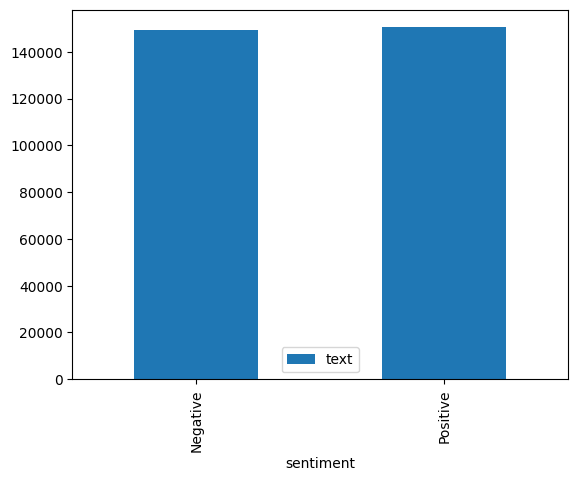

In [ ]:
#check if classes are unbalanced
df_plot = df.copy()
df_plot = df.drop(['stemmed_tweets','tweets_filtered', 'lemmatized_words'], axis = 1)
df_plot.groupby('sentiment').count().plot(kind='bar')

Mean tweet length: 39.39777333333333


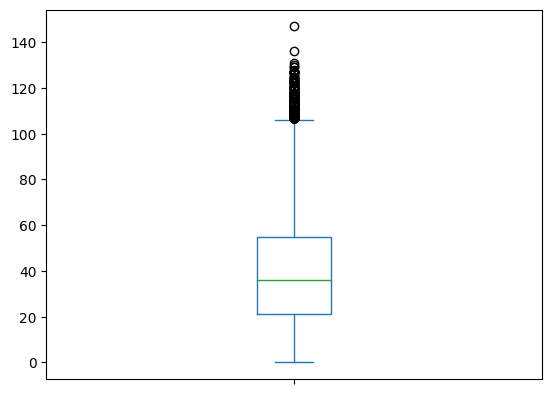

In [ ]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet) for tweet in df['stemmed_tweets']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

mean_tweet_len = tweet_len.mean()
print("Mean tweet length:", mean_tweet_len)

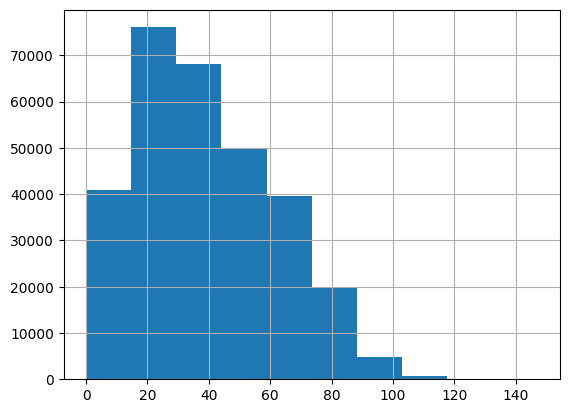

count    300000.000000
mean         39.397773
std          22.369354
min           0.000000
25%          21.000000
50%          36.000000
75%          55.000000
max         147.000000
dtype: float64

In [ ]:
#another representation of tweets lenght with some statics as well
tweets_len = [len(tweet) for tweet in df['stemmed_tweets']]
pd.Series(tweets_len).hist()
plt.show()
pd.Series(tweets_len).describe()

In [ ]:
count = sum(1 for length in tweets_len if length > 77)
print( "number of tweets longer then 77: {}".format(count) )

number of tweets longer then 77: 17956


In [ ]:
#join all tweet labeled with the same sentiment
tweets_by_sentiment = df.groupby('sentiment')['text'].apply(lambda x: ' '.join(x))
tweets_by_sentiment

sentiment
Negative    ahhh i hope your ok cool i have no tweet apps ...
Positive    on lunch dj should come eat with me thank you ...
Name: text, dtype: object

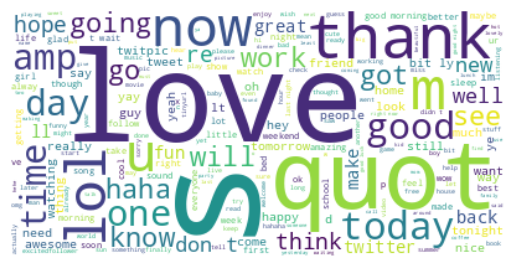

In [ ]:
# Create a WordCloud object and generate the word cloud
wc = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(tweets_by_sentiment['Positive'])

# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

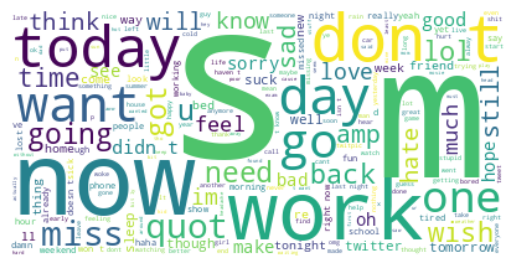

In [ ]:
# Create a WordCloud object and generate the word cloud
wc = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steelblue')
wc.generate(tweets_by_sentiment['Negative'])

# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

##Train Test split

In [ ]:
# Import functions from sklearn library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2,random_state=16)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 240000
Test Data size 60000


## Naive Bayes Model


In [81]:
y_train = train_data['sentiment']
y_test = test_data['sentiment']

In [82]:
train_tweets = train_data['lemmatized_words']
test_tweets = test_data['lemmatized_words']

count_vectorizer = CountVectorizer(binary=True)
count_vectorizer.fit(train_tweets)

CountVectorizer(binary=True)

In [83]:
# transform data using CountVectorizer
train_counts = count_vectorizer.transform(train_tweets)
test_counts = count_vectorizer.transform(test_tweets)

# get names of words that appear in at least 500 tweets
feature_names = count_vectorizer.get_feature_names_out()
freq_count = np.array(train_counts.sum(axis=0))
predictors = np.array(feature_names)[freq_count[0] >= 500]
print(len(predictors))

542


In [84]:
#Takes 10mins

results = pd.DataFrame(columns=['Loss NB'])

for word in predictors:
    word_index = count_vectorizer.vocabulary_[word]
    X_train = np.asarray(train_counts[:, word_index].todense())
    X_test = np.asarray(test_counts[:, word_index].todense())

    nbc = BernoulliNB().fit(X_train, y_train)

    prob = nbc.predict_proba(X_train)
    results.loc[word] = log_loss(y_train, prob)

In [85]:
results.sort_values('Loss NB').head(10)

,Loss NB
sad,0.684496
thanks,0.685916
miss,0.686977
love,0.688392
hate,0.688888
good,0.689118
sick,0.689261
bad,0.689764
thank,0.689846
sorry,0.689933


In [86]:
ordered_predictors = list(results.sort_values('Loss NB').index)

In [87]:
def compute_naive_bayes_model(n_predictors):
    # Identify the columns corresponding to the predictors we are using
    indices = []
    for word in ordered_predictors[:n_predictors+1]:
        #indices.append(count_vectorizer.get_feature_names().index(word))
        indices.append(count_vectorizer.vocabulary_[word])
    
    X_train = np.asarray(train_counts[:, indices].todense())
    X_test = np.asarray(test_counts[:, indices].todense())
    
    nbc = BernoulliNB().fit(X_train, y_train)

    pred = cross_val_predict(nbc, X_train, y_train, cv=5)
    error = 1 - accuracy_score(pred, y_train)
    
    return error*100

In [88]:
cv_errors = []
predictor_range = range(0, len(ordered_predictors), 50)

for n_predictors in predictor_range:
    cv_errors.append(compute_naive_bayes_model(n_predictors))

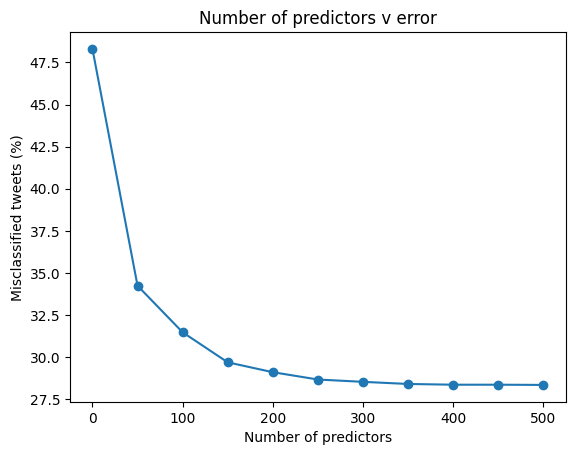

In [89]:
plt.plot(predictor_range, cv_errors, '-o')
plt.xlabel('Number of predictors')
plt.ylabel('Misclassified tweets (%)')
plt.title('Number of predictors v error');

In [90]:
print('Number of predictors:', predictor_range[np.argmin(cv_errors)])
print('Error: {:.1f}'.format(cv_errors[np.argmin(cv_errors)]))

Number of predictors: 500
Error: 28.4


In [91]:
cv_errors

[48.30583333333334,
 34.24166666666667,
 31.476666666666663,
 29.69333333333334,
 29.10708333333333,
 28.6725,
 28.53458333333333,
 28.408333333333335,
 28.364583333333336,
 28.364583333333336,
 28.351666666666663]

In [92]:
indices = []
for word in ordered_predictors[:350]:
    #indices.append(count_vectorizer.get_feature_names().index(word))
    indices.append(count_vectorizer.vocabulary_[word])
    
X_train = np.asarray(train_counts[:, indices].todense())
X_test = np.asarray(test_counts[:, indices].todense())

In [93]:
param_grid = {'alpha': [0.001, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))


grid_search = GridSearchCV(BernoulliNB(), param_grid, cv=10,                    
return_train_score=True)

grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Parameter grid:
{'alpha': [0.001, 0.1, 1, 10, 100]}
Test set score: 0.72
Best parameters: {'alpha': 1}
Best cross-validation score: 0.72
Best estimator:
BernoulliNB(alpha=1)


In [94]:
nbc = BernoulliNB(alpha = 1).fit(X_train, y_train)

pred = nbc.predict(X_test)
prob = nbc.predict_proba(X_test)[:, 1] # probability of the positive class

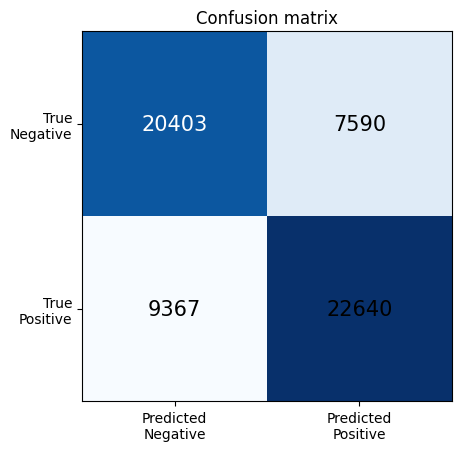

In [95]:
cm = confusion_matrix(y_test, pred)
plt.imshow(cm, cmap='Blues')

plt.text(0, 0, cm[0, 0], ha="center", va="center", color="w", fontsize = 15) 
plt.text(0, 1, cm[0, 1], ha="center", va="center", color="k", fontsize = 15) 
plt.text(1, 0, cm[1, 0], ha="center", va="center", color="k", fontsize = 15) 
plt.text(1, 1, cm[1, 1], ha="center", va="center", color="k", fontsize = 15) 
plt.xticks([0, 1], ['Predicted\nNegative', 'Predicted\nPositive'])    
plt.yticks([0, 1], ['True\nNegative', 'True\nPositive'])    
plt.title('Confusion matrix')
plt.show()

In [96]:
print(metrics.classification_report(y_test, pred))


              precision    recall  f1-score   support

    Negative       0.73      0.69      0.71     29770
    Positive       0.71      0.75      0.73     30230

    accuracy                           0.72     60000
   macro avg       0.72      0.72      0.72     60000
weighted avg       0.72      0.72      0.72     60000



## Log Reg

In [97]:
results_SGD = pd.DataFrame(columns=['Loss SGD'])

for word in predictors:
    word_index = count_vectorizer.vocabulary_[word]
    X_train = np.asarray(train_counts[:, word_index].todense())
    X_test = np.asarray(test_counts[:, word_index].todense())

    sgd = SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=1000, tol=1e-3)
    sgd.fit(X_train, y_train)

    prob = sgd.predict_proba(X_train)
    results_SGD.loc[word] = log_loss(y_train, prob)


In [98]:
ordered_predictors_SGD = list(results_SGD.sort_values('Loss SGD').index)

In [99]:
def compute_sgd_model(n_predictors):
    # Identify the columns corresponding to the predictors we are using
    indices = []
    for word in ordered_predictors_SGD[:n_predictors+1]:
        #indices.append(count_vectorizer.get_feature_names().index(word))
        indices.append(count_vectorizer.vocabulary_[word])
    
    X_train = np.asarray(train_counts[:, indices].todense())
    X_test = np.asarray(test_counts[:, indices].todense())
    
    sgd = SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=1000, tol=1e-3)
    sgd.fit(X_train, y_train)

    pred = cross_val_predict(sgd, X_train, y_train, cv=5)
    error = 1 - accuracy_score(pred, y_train)
    
    return error*100

In [100]:
cv_errors_SGD = []
predictor_range_SGD = range(0, len(ordered_predictors_SGD), 50)

for n_predictors in predictor_range_SGD:
    cv_errors_SGD.append(compute_sgd_model(n_predictors))

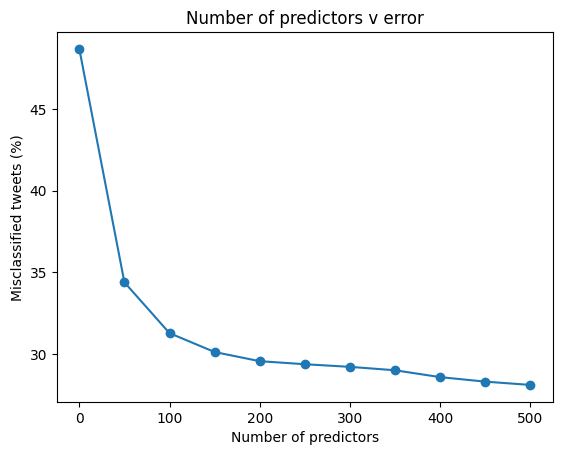

In [101]:
plt.plot(predictor_range_SGD, cv_errors_SGD, '-o')
plt.xlabel('Number of predictors')
plt.ylabel('Misclassified tweets (%)')
plt.title('Number of predictors v error');

In [102]:
print('Number of predictors:', predictor_range_SGD[np.argmin(cv_errors_SGD)])
print('Error: {:.1f}'.format(cv_errors_SGD[np.argmin(cv_errors_SGD)]))

Number of predictors: 500
Error: 28.1


In [103]:
cv_errors_SGD

[48.66083333333333,
 34.394999999999996,
 31.289166666666667,
 30.13458333333333,
 29.574999999999996,
 29.389583333333334,
 29.228750000000005,
 29.019583333333333,
 28.60125,
 28.32541666666667,
 28.12375]

In [104]:
indices = []
for word in ordered_predictors_SGD[:500]:
    #indices.append(count_vectorizer.get_feature_names().index(word))
    indices.append(count_vectorizer.vocabulary_[word])
    
X_train = np.asarray(train_counts[:, indices].todense())
X_test = np.asarray(test_counts[:, indices].todense())

In [105]:
param_grid = {'alpha': [0.0001,0.001, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SGDClassifier(loss='log_loss'), param_grid, cv=10,
return_train_score=True)

grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.72
Best parameters: {'alpha': 0.0001}
Best cross-validation score: 0.72
Best estimator:
SGDClassifier(loss='log_loss')


In [106]:
sgd = SGDClassifier(loss='log_loss', alpha=0.0001)
sgd.fit(X_train, y_train)

pred = sgd.predict(X_test)
prob = sgd.predict_proba(X_test)[:, 1] # probability of the positive class

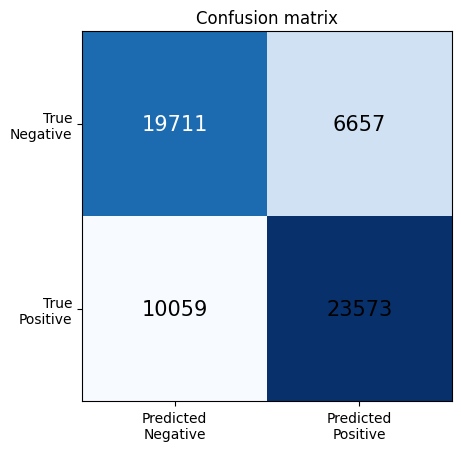

In [107]:
cm = confusion_matrix(y_test, pred)
plt.imshow(cm, cmap='Blues')

plt.text(0, 0, cm[0, 0], ha="center", va="center", color="w", fontsize = 15) 
plt.text(0, 1, cm[0, 1], ha="center", va="center", color="k", fontsize = 15) 
plt.text(1, 0, cm[1, 0], ha="center", va="center", color="k", fontsize = 15) 
plt.text(1, 1, cm[1, 1], ha="center", va="center", color="k", fontsize = 15) 
plt.xticks([0, 1], ['Predicted\nNegative', 'Predicted\nPositive'])    
plt.yticks([0, 1], ['True\nNegative', 'True\nPositive'])    
plt.title('Confusion matrix')
plt.show()

In [108]:
print(metrics.classification_report(y_test, pred))


              precision    recall  f1-score   support

    Negative       0.75      0.66      0.70     29770
    Positive       0.70      0.78      0.74     30230

    accuracy                           0.72     60000
   macro avg       0.72      0.72      0.72     60000
weighted avg       0.72      0.72      0.72     60000



#LSTM

##Preprocessing

In [ ]:
# The tokens are converted into sequences and then passed to the pad_sequences() function
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.lemmatized_words)   #stemmed_tweets
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.lemmatized_words),maxlen = 77)    #stemmed_tweets
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.lemmatized_words),maxlen = 77)      #stemmed_tweets

In [ ]:
#target variable is encoded as: Negative->0, Positive->1
labels = ['Negative', 'Positive']
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())
y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
print(x_train.shape,x_test.shape)
print(y_train.shape, y_test.shape)

(240000, 77) (60000, 77)
(240000, 1) (60000, 1)


##Words embedding (with Glove)

In [ ]:
#dowload and unzip Glove
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [ ]:
#create a word_index that contains only unique tokens
#note that a lower integer index will be asssigned to words that appear earlier in the dataset
word_index = tokenizer.word_index
print('number of unique tokens: {}'.format(len(word_index)+1))

number of unique tokens: 94428


In [ ]:
#create a dictionary with key = word, values = word vector of 300 floats 
# words come from the glove dictionary
embeddings_index = {}
with open('/gdrive/My Drive/MachineLearningUSYD/Assignment2COMP4318/glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [ ]:
# word_index is a dictionary from glove that maps words to integers
#create a dense matrix where each row i corresponds to the embedding vector for the word at index i in the word_index
embedding_matrix = np.zeros((len(word_index)+1, 300))
print(embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i, :] = embedding_vector

(94428, 300)


##Neural Network model (LSTM)

In [66]:
SIZE_EMBEDDING = 300
INPUT_SEQUENCE_LENGHT = 77
VOCAB_SIZE = len(word_index)+1

In [67]:
model = Sequential([
    
    Input(shape=(INPUT_SEQUENCE_LENGHT,), dtype='int32'),
    Embedding(VOCAB_SIZE, SIZE_EMBEDDING, input_length=INPUT_SEQUENCE_LENGHT, trainable=False, weights=[embedding_matrix]),
    Bidirectional(LSTM(77, dropout=0.2, recurrent_dropout=0.2)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    
    ])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 77, 300)           28328400  
                                                                 
 bidirectional_3 (Bidirectio  (None, 154)              232848    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 512)               79360     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                      

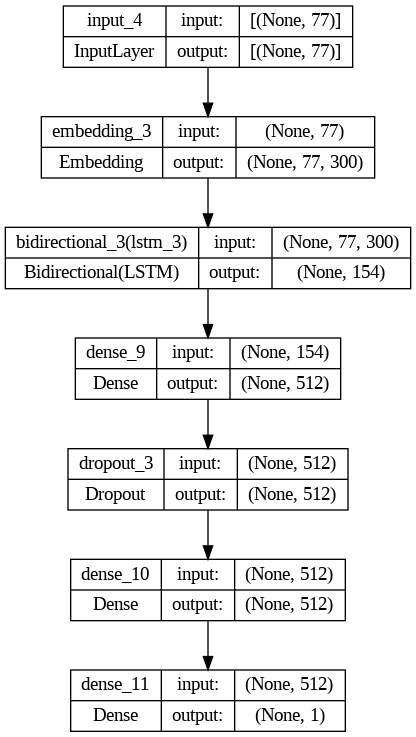

In [68]:
model.summary()
plot_model(model, to_file='model_summary.png', show_shapes=True)

In [69]:
#adaptive learning rate technique so that the learning rate is decreased when we get to a plateau (val_loss stops emproving)
lr_scheduling= ReduceLROnPlateau(factor=0.1, min_lr = 0.00001, monitor = 'val_loss', verbose = 1, patience=5) 
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [70]:
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle = True)


In [71]:
history = model.fit(x_train_2, y_train_2, batch_size=512, epochs=30,
                    validation_data=(x_val, y_val), callbacks=[lr_scheduling,early_stop,checkpoint])
model.load_weights('best_weights.h5')

Epoch 1/30
375/375 [==============================] - 91s 228ms/step - loss: 0.5491 - accuracy: 0.7159 - val_loss: 0.5066 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 87s 231ms/step - loss: 0.5068 - accuracy: 0.7489 - val_loss: 0.4900 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 86s 229ms/step - loss: 0.4899 - accuracy: 0.7612 - val_loss: 0.4786 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 85s 227ms/step - loss: 0.4767 - accuracy: 0.7696 - val_loss: 0.4816 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 86s 231ms/step - loss: 0.4670 - accuracy: 0.7760 - val_loss: 0.4732 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 86s 229ms/step - loss: 0.4593 - accuracy: 0.7805 - val_loss: 0.4721 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 7/30
375/375 [==============================] 

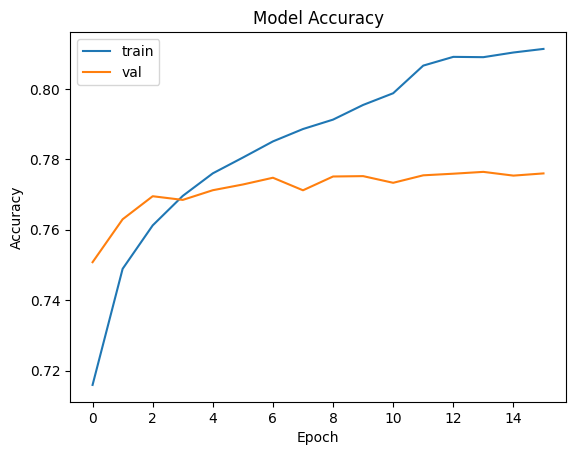

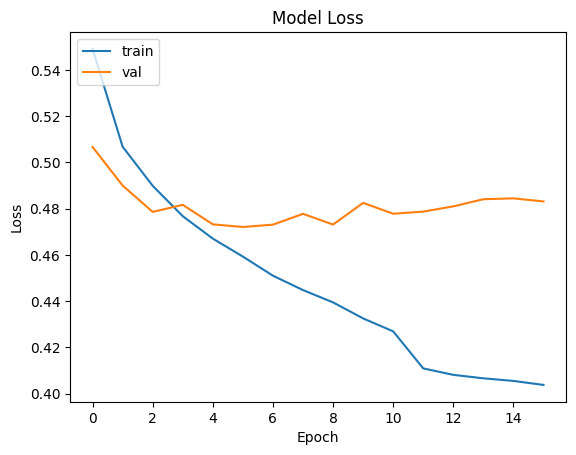

In [72]:
# plot training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [73]:
model.save('LSTM_100_lr0.001')

##Predictions

In [77]:
def predict_tweet_sentiment(score):
    return "Positive" if score>0.5 else "Negative"
scores = model.predict(x_test, verbose=1, batch_size=10000)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

6/6 [==============================] - 2s 271ms/step


In [78]:
from sklearn.metrics import classification_report
print(classification_report(list(test_data.sentiment), model_predictions))

              precision    recall  f1-score   support

    Negative       0.78      0.76      0.77     29770
    Positive       0.77      0.79      0.78     30230

    accuracy                           0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000



In [80]:
from sklearn.metrics import confusion_matrix

model_predictions_binary = np.where(np.array(model_predictions) == "Positive", 1, 0)

# Create the confusion matrix
confusion_matrix = confusion_matrix(y_test, model_predictions_binary)
print(confusion_matrix)

[[22648  7122]
 [ 6446 23784]]
